In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
from pymatgen.core import Composition

from foundation_model.utils.interpolate import InterpSmooth

InteractiveShell.instance().ast_node_interactivity = "all"

2025-06-11 22:55:35.976 | INFO     | __init__:<module>:34 - Loguru logger initialized for foundation_model package.


In [2]:
from typing import Optional, Union


def is_empty_list(x):
    return isinstance(x, str) and x == "[]"


def convert_mass_magnetization(
    comp: Composition, mass_magnetization: Union[float, np.ndarray], cgs_to_si: bool = True
) -> Union[float, np.ndarray]:
    """
    转换质量磁化率的单位，根据布尔参数决定转换方向。
    支持 mass_magnetization 为标量或 numpy 数组的情况。

    参数:
        comp: pymatgen.core.composition.Composition
            物质的化学组成，用于计算摩尔质量 (g/mol)。
        mass_magnetization: float 或 numpy.ndarray
            - 当 cgs_to_si 为 True 时，表示 CGS 制的质量磁化率 (emu/g)；
            - 当 cgs_to_si 为 False 时，表示 SI 制的摩尔磁矩 (A·m²/mol)。
            可以是单个浮点数，也可以是 numpy 数组。
        cgs_to_si: bool, 默认 True
            转换方向选择：
                True  : 从 CGS (emu/g) 转换到 SI (A·m²/mol)
                False : 从 SI (A·m²/mol) 转换到 CGS (emu/g)

    返回:
        float 或 numpy.ndarray:
            转换后的磁化率数值。
            - 如果 cgs_to_si=True，单位为 A·m²/mol；
            - 如果 cgs_to_si=False，单位为 emu/g。
            如果输入是 numpy 数组，则返回相同形状的 numpy 数组；
            如果输入是标量，则返回标量浮点数。
    """
    # 计算摩尔质量 (g/mol)
    molar_mass = comp.weight  # g/mol

    # 将输入转为 numpy 数组以便支持数组运算
    mm_arr = np.asarray(mass_magnetization, dtype=float)

    if cgs_to_si:
        # 从 CGS 转换到 SI:
        # mass_magnetization (emu/g) * molar_mass (g/mol) = emu/mol
        # 1 emu = 1e-3 A·m², 所以转换为 SI 得到 A·m²/mol
        result_arr = mm_arr * molar_mass * 1e-3
    else:
        # 从 SI 转换到 CGS:
        # mass_magnetization 表示 SI 制 (A·m²/mol)
        # 先转换为 emu/mol: 1 A·m² = 1e3 emu, 然后除以 molar_mass (g/mol) 得到 emu/g
        result_arr = mm_arr * 1e3 / molar_mass

    # 如果输入是标量 (0 维数组)，将结果转回浮点数
    if result_arr.ndim == 0:
        return float(result_arr)
    return result_arr


def convert_composition(comp: str) -> Optional[Composition]:
    try:
        c = Composition(comp)
        if len(c) == 0:
            return None
        return c
    except Exception:
        return None


def format_title(text: str, to_snake: bool = False, skip_list: Optional[list[str]] = None) -> str:
    """
    格式化输入文本为首字母大写格式或蛇形命名法，并支持指定不需要格式化的单词。

    参数:
        text : str
            输入文本。
        to_snake : bool, 可选
            是否转换为蛇形命名法，默认为 False。
        skip_list : list[str], 可选
            指定部分单词不做格式化，默认为 None。

    返回:
        str
            格式化后的文本。
    """
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    if text is None or text.strip() == "":
        return text

    if skip_list is None:
        skip_list = []

    if to_snake:
        # 将空格拆分为单词，并转换为蛇形命名法，保留skip_list中的单词不变
        words = text.strip().split()
        formatted = [word if word in skip_list else word.lower() for word in words]
        return "_".join(formatted)
    else:
        # 将下划线替换为空格，并分割成单词
        words = text.replace("_", " ").strip().split()
        if not words:
            return text
        # 格式化：第一个单词首字母大写，其他单词全部小写（除非在skip_list中）
        formatted = []
        for i, word in enumerate(words):
            if word in skip_list:
                formatted.append(word)
            else:
                formatted.append(word.capitalize() if i == 0 else word.lower())
        return " ".join(formatted)

#### QC AC data

In [3]:
qc_ac_dataset = (
    pd.read_csv("../raw/HYPOD-X_20250121/properties_dataset.csv")
    .dropna()
    .drop(columns=["sample_name", "figure_id", "degree_of_approximant", "SID"])
)
qc_ac_dataset = qc_ac_dataset.rename(columns={"composition": "formula", "QC_or_AC_type": "hypermaterial_type"})

# Drop Specific heat since these value is to describe the temperature derivative of the molar heat capacity or the second-order temperature effects
qc_ac_dataset = qc_ac_dataset[
    ~qc_ac_dataset.prop_y.isin(["Specific heat", "Specific heat capacity", "Hall coefficient", "Thermal diffusivity"])
]

# Try to convert the composition string to the Composition object
qc_ac_dataset = qc_ac_dataset.assign(composition=qc_ac_dataset["formula"].apply(convert_composition)).dropna()
qc_ac_dataset = qc_ac_dataset.assign(
    elements=qc_ac_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements]))
)

# Align unit of Magnetic susceptibility
tmp = qc_ac_dataset[qc_ac_dataset.unit_y == "emu*g^(-1)"]
tmp = tmp.assign(
    unit_y="A*m**2/mol", y=[convert_mass_magnetization(comp, y) for comp, y in zip(tmp.composition, tmp.y)]
)
qc_ac_dataset.update(tmp)


qc_ac_dataset.unit_y.unique()
qc_ac_dataset.prop_y.unique()
qc_ac_dataset.shape
qc_ac_dataset.head(3)

array(['Ohm*m', 'W*m^(-1)*K^(-1)', 'V*K^(-1)', 'W*m^(-1)*K^(-2)', '-',
       'A*m**2/mol'], dtype=object)

array(['Electrical resistivity', 'Thermal conductivity',
       'Seebeck coefficient', 'Power factor', 'ZT',
       'Magnetic susceptibility'], dtype=object)

(49460, 12)

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,9.608498,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
1,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,19.835030,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
2,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,31.782880,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"


In [9]:
qc_ac_dataset_rebuild = []
f_, p_ = "", ""
for (f, p, s), data in qc_ac_dataset.groupby(["formula", "prop_y", "sample_id"]):
    if (f_, p_) == (f, p):
        continue
    if len(data.x) <= 10:
        continue
    if max(data.x) - min(data.x) < 50.0:
        continue
    f_, p_ = f, p

    # 设置 start 和 end 为 data.x 的最小值和最大值
    start = int(np.ceil(data.x.min()))
    end = int(np.floor(data.x.max()))
    x_new = np.linspace(start, end, 300)

    interp = InterpSmooth(data.x.to_numpy(), data.y.to_numpy(), smooth_method="savgol")
    y_sgol = interp(x_new, s_factor=30.0)
    # y_sgol = interp(x_new, s_factor=30.0, normalize=True)
    tmp = data.iloc[0].copy()
    tmp.x = data.x.tolist()
    tmp.y = data.y.tolist()
    tmp["temperature"] = x_new.tolist()
    tmp["property_value"] = y_sgol.tolist()

    qc_ac_dataset_rebuild.append(tmp)

qc_ac_dataset_rebuild = (
    pd.DataFrame(qc_ac_dataset_rebuild)
    .rename(columns={"prop_y": "property", "unit_y": "unit", "x": "raw_x", "y": "raw_y"})
    .drop(columns=["prop_x", "unit_x"])
)

# qc_ac_dataset_rebuild.property = qc_ac_dataset_rebuild.property.apply(lambda x: f"{x} (normalized)")
qc_ac_dataset_rebuild = qc_ac_dataset_rebuild.set_index([[f"qa-{i}" for i in qc_ac_dataset_rebuild.index]], drop=True)
qc_ac_dataset_rebuild.head(3)
qc_ac_dataset_rebuild.shape
qc_ac_dataset_rebuild.property.value_counts()

# Save the processed dataset
qc_ac_dataset_rebuild.to_pickle("../processed_qc_ac_dataset_20250121.pd.xz")

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
qa-34653,Al61.5Cu26.5Fe12,IQC,Seebeck coefficient,V*K^(-1),"[100.253, 122.1073, 139.211, 159.1709, 180.081...","[-1.04e-05, -1.08e-05, -1.12e-05, -1.13e-05, -...",57966,10.1007/s11664-014-3204-4,"(Al, Cu, Fe)","(Al, Cu, Fe)","[101.0, 102.67558528428094, 104.35117056856187...","[-1.0417768625125885e-05, -1.0446056342025495e..."
qa-6872,Ag42.25In42.25Yb15.5,IQC,Electrical resistivity,Ohm*m,"[5.68044, 12.19651, 18.7126, 25.22901, 31.7462...","[2.26e-06, 2.26e-06, 2.26e-06, 2.26e-06, 2.26e...",35352,10.1103/physrevb.72.054202,"(Ag, In, Yb)","(Ag, In, Yb)","[6.0, 6.976588628762542, 7.953177257525084, 8....","[2.2592779044343682e-06, 2.2594851609857537e-0..."
qa-7129,Ag42.25In42.25Yb15.5,IQC,Seebeck coefficient,V*K^(-1),"[8.71879, 14.32364, 16.10026, 19.74174, 23.513...","[1.3e-06, 1.8e-06, 2.139e-06, 2.48e-06, 2.76e-...",35352,10.1103/physrevb.72.054202,"(Ag, In, Yb)","(Ag, In, Yb)","[9.0, 9.96989966555184, 10.939799331103679, 11...","[1.2598639816506936e-06, 1.386409585397821e-06..."


(654, 12)

property
Electrical resistivity     361
Seebeck coefficient        141
Thermal conductivity        72
Magnetic susceptibility     42
Power factor                25
ZT                          13
Name: count, dtype: int64

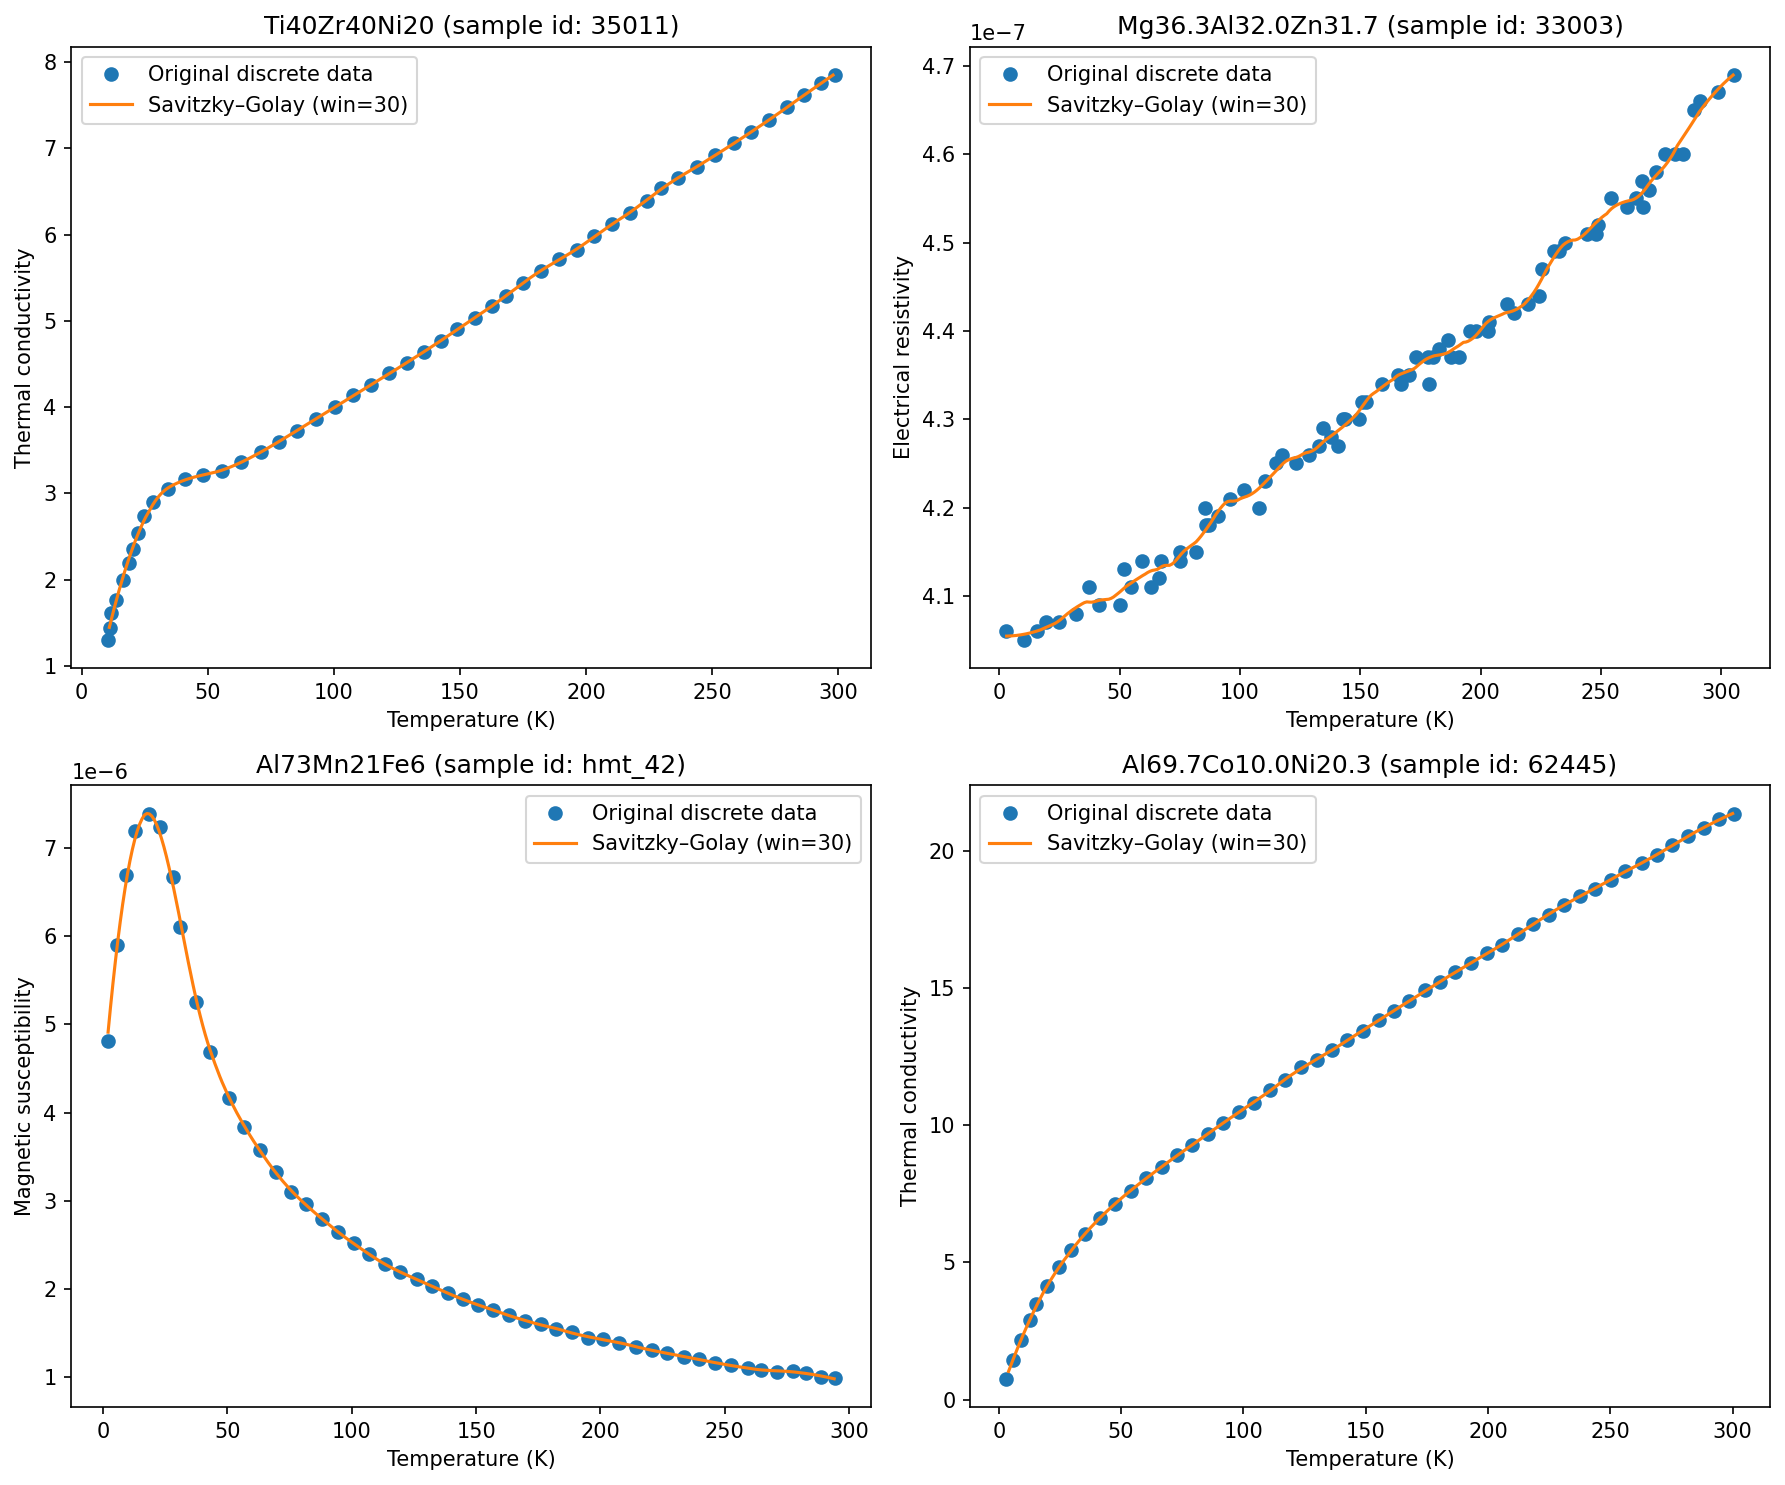

In [10]:
np.random.seed(8)  # 设置随机种子
# select_data = qc_ac_dataset_rebuild[qc_ac_dataset_rebuild.property.isin(["ZT", "Power factor"])]
select_data = qc_ac_dataset_rebuild
random_indices = np.random.choice(len(select_data), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.ravel()

for idx, i in enumerate(random_indices):
    tmp = select_data.iloc[i]
    x_new = tmp.temperature
    y_new = tmp.property_value

    _ = axes[idx].plot(tmp.raw_x, tmp.raw_y, "o", label="Original discrete data")
    _ = axes[idx].plot(x_new, y_new, "-", lw=1.5, label="Savitzky–Golay (win=30)")
    _ = axes[idx].set_xlabel("Temperature (K)")
    _ = axes[idx].set_ylabel(tmp.property)
    _ = axes[idx].legend(loc="best")
    _ = axes[idx].set_title(f"{tmp.formula} (sample id: {tmp.sample_id})")

plt.tight_layout()
plt.show()


#### starry data

In [6]:
starry_dataset = pd.read_csv("../raw/starrydata_dataset_20250531/starrydata_curves.csv")
mask = starry_dataset.map(is_empty_list)
rows_to_drop = mask.any(axis=1)
starry_dataset = starry_dataset[~rows_to_drop]

starry_dataset = starry_dataset.rename(columns={"composition": "formula"})
starry_dataset = starry_dataset.assign(
    prop_x=starry_dataset.prop_x.apply(lambda s: format_title(s, to_snake=False)),
    prop_y=starry_dataset.prop_y.apply(lambda s: format_title(s, to_snake=False, skip_list=["ZT"])),
    unit_x=starry_dataset.unit_x.apply(lambda s: format_title(s, to_snake=False)),
    unit_y=starry_dataset.unit_y.apply(lambda s: format_title(s, to_snake=False)),
    x=starry_dataset.x.apply(eval),
    y=starry_dataset.y.apply(eval),
)

# Drop extremely small data
starry_dataset = starry_dataset[starry_dataset.unit_x == "K"]
starry_dataset = starry_dataset[~starry_dataset.unit_y.isin(["V", "V/k"])]
starry_dataset = starry_dataset[
    starry_dataset.prop_y.isin(
        [
            "Seebeck coefficient",
            "Thermal conductivity",
            "ZT",
            "Power factor",
            "Electrical resistivity",
            "Magnetic susceptibility",
        ]
    )
]
starry_dataset = starry_dataset[
    starry_dataset.prop_y.isin(starry_dataset.prop_y.unique()[starry_dataset.prop_y.value_counts() >= 100])
]

starry_dataset = starry_dataset[
    ~starry_dataset.sample_id.isin([int(i) for i in qc_ac_dataset.sample_id if not i.startswith("hmt")])
].assign(hypermaterial_type="others")
starry_dataset = starry_dataset[
    ["formula", "hypermaterial_type", "prop_x", "prop_y", "unit_x", "unit_y", "x", "y", "sample_id", "DOI"]
].dropna()

# Try to convert the composition string to the Composition object
starry_dataset = starry_dataset.assign(composition=starry_dataset["formula"].apply(convert_composition)).dropna(
    subset=["composition"]
)
starry_dataset = starry_dataset.assign(
    elements=starry_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements]))
)

# Align unit of Magnetic susceptibility
tmp = starry_dataset[(starry_dataset.unit_y == "emu*g^(-1)") | (starry_dataset.unit_y == "Emu/g")]
tmp = tmp.assign(
    unit_y="A*m**2/mol", y=[convert_mass_magnetization(comp, y).tolist() for comp, y in zip(tmp.composition, tmp.y)]
)
starry_dataset.update(tmp)

starry_dataset.unit_y.unique()
starry_dataset.prop_y.unique()
starry_dataset.head(3)
starry_dataset.shape

array(['V*k^(-1)', 'W*m^(-1)*k^(-1)', 'Ohm*m', 'W*m^(-1)*k^(-2)', '-',
       'A*m**2/mol'], dtype=object)

array(['Seebeck coefficient', 'Thermal conductivity',
       'Electrical resistivity', 'Power factor', 'ZT',
       'Magnetic susceptibility'], dtype=object)

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Pb1.00025Zn0.02Te1.02I0.0005,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[299.8597, 324.8683, 349.8757, 375.2454, 399.8...","[-0.0001484452, -0.0001602763, -0.0001729511, ...",113,10.1021/am405410e,"(Pb, Zn, Te, I)","(Pb, Zn, Te, I)"
1,Na0.0035Pb0.9965Se1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[317.7914, 379.1411, 384.0491, 431.9018, 452.7...","[7.27595e-05, 7.374922e-05, 9.257471e-05, 0.00...",147,10.1002/adma.201004200,"(Na, Pb, Se)","(Na, Pb, Se)"
2,Pb1.03Sb0.03Te1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[333.1159, 340.5494, 347.983, 355.4166, 362.85...","[-2.35374e-05, -2.455838e-05, -2.681692e-05, -...",434,10.1002/anie.200803934,"(Pb, Sb, Te)","(Pb, Sb, Te)"


(111261, 12)

In [11]:
starry_dataset_rebuild = []
f_, p_ = "", ""
for (f, p, s), data in starry_dataset.groupby(["formula", "prop_y", "sample_id"]):
    data = data.iloc[0]
    if (f_, p_) == (f, p):
        continue
    if len(data.x) <= 10:
        continue
    if max(data.x) - min(data.x) < 50.0:
        continue
    f_, p_ = f, p

    # 设置 start 和 end 为 data.x 的最小值和最大值
    start = int(np.ceil(min(data.x)))
    end = int(np.floor(max(data.x)))
    x_new = np.linspace(start, end, 300)

    interp = InterpSmooth(data.x, data.y, smooth_method="savgol")
    y_sgol = interp(x_new, s_factor=30.0)
    # y_sgol = interp(x_new, s_factor=30.0, normalize=True)

    tmp = data.copy()
    tmp["temperature"] = x_new.tolist()
    tmp["property_value"] = y_sgol.tolist()

    starry_dataset_rebuild.append(tmp)

starry_dataset_rebuild = (
    pd.DataFrame(starry_dataset_rebuild)
    .rename(columns={"prop_y": "property", "unit_y": "unit", "x": "raw_x", "y": "raw_y"})
    .drop(columns=["prop_x", "unit_x"])
)

# starry_dataset_rebuild.property = starry_dataset_rebuild.property.apply(lambda x: f"{x} (normalized)")
starry_dataset_rebuild = starry_dataset_rebuild.set_index(
    [[f"starry-{i}" for i in starry_dataset_rebuild.index]], drop=True
)
starry_dataset_rebuild.head(3)
starry_dataset_rebuild.shape
starry_dataset_rebuild.property.value_counts()

# Save the processed dataset
starry_dataset_rebuild.to_pickle("../processed_starrydata_dataset_20250531.pd.xz")

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
starry-6210,\t(Pb0.92Mg0.08)0.98Na0.02Te0.8Se0.2,others,Seebeck coefficient,V*k^(-1),"[298.6339, 320.4918, 342.3497, 360.1093, 379.2...","[4.44379e-05, 5.668781e-05, 7.153834e-05, 8.63...",2717,10.1016/j.jmat.2016.05.005,"(Pb, Mg, Na, Te, Se)","(Pb, Mg, Na, Te, Se)","[299.0, 300.74247491638795, 302.4849498327759,...","[4.474974492452031e-05, 4.56635953000925e-05, ..."
starry-6233,\t(Pb0.92Mg0.08)0.98Na0.02Te0.8Se0.2,others,ZT,-,"[821.843, 798.6348, 780.8874, 760.4096, 741.29...","[2.28777, 2.172662, 2.043165, 1.928058, 1.7985...",2717,10.1016/j.jmat.2016.05.005,"(Pb, Mg, Na, Te, Se)","(Pb, Mg, Na, Te, Se)","[304.0, 305.72909698996654, 307.4581939799331,...","[0.025598609209255378, 0.025669826147823413, 0..."
starry-5894,\t(Pb0.94Sr0.06)0.98Na0.02Te,others,Power factor,W*m^(-1)*k^(-2),"[339.6491, 374.7368, 425.2632, 470.1754, 522.1...","[0.0002236417, 0.0002840224, 0.00038486, 0.000...",2663,10.1016/j.jallcom.2016.06.172,"(Pb, Sr, Na, Te)","(Pb, Sr, Na, Te)","[340.0, 341.561872909699, 343.123745819398, 34...","[0.00022424554657957056, 0.0002269332969763951..."


(45312, 12)

property
Seebeck coefficient        14143
Electrical resistivity      8912
Thermal conductivity        8144
ZT                          7410
Power factor                6633
Magnetic susceptibility       70
Name: count, dtype: int64

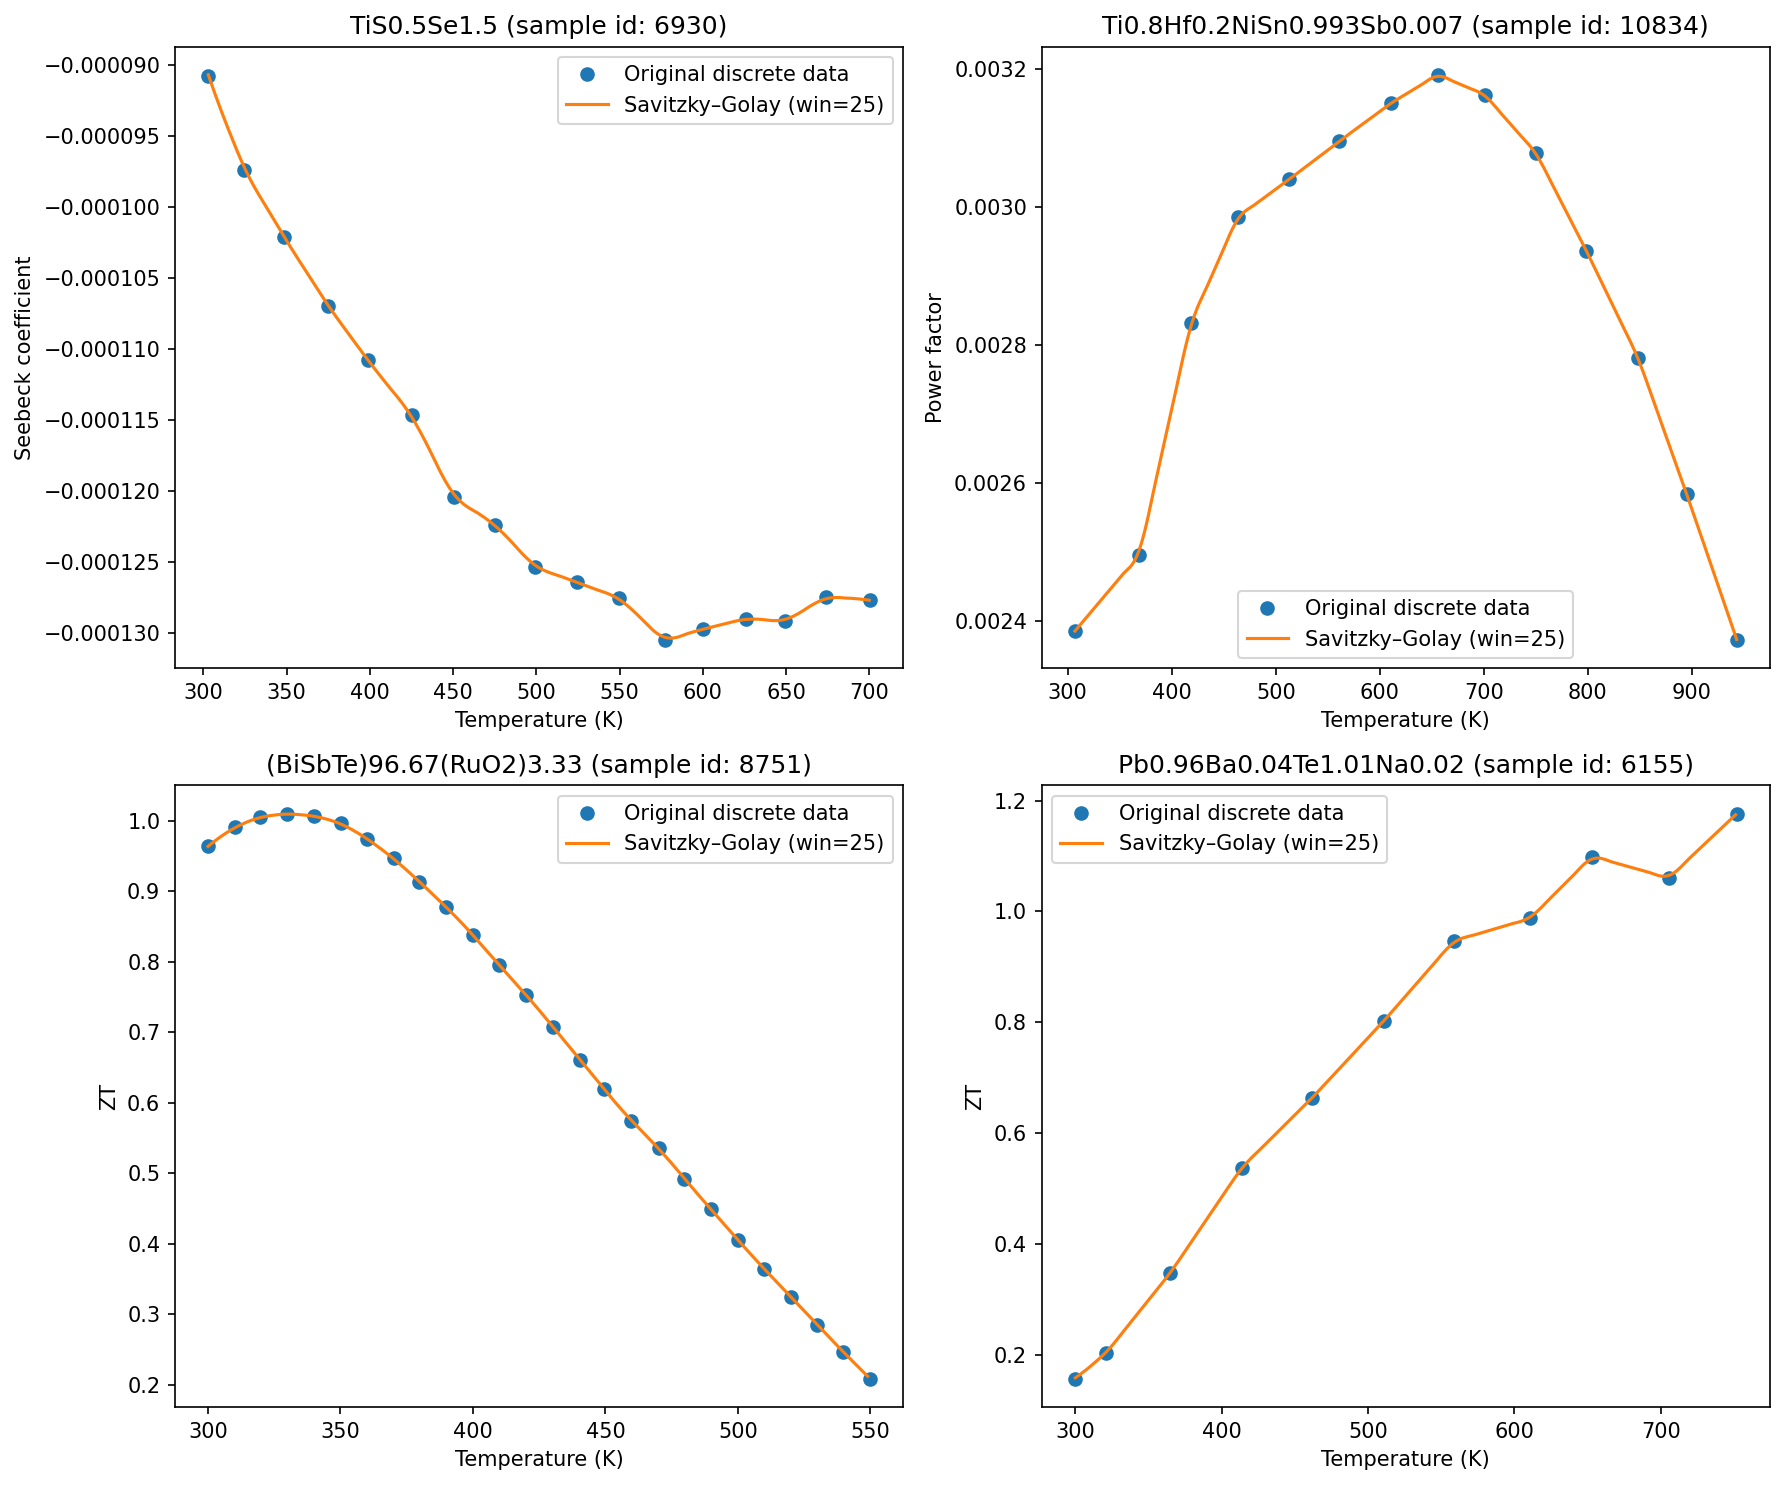

In [12]:
np.random.seed(4)  # 设置随机种子
random_indices = np.random.choice(len(starry_dataset_rebuild), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.ravel()

for idx, i in enumerate(random_indices):
    tmp = starry_dataset_rebuild.iloc[i]
    x_new = tmp.temperature
    y_new = tmp.property_value

    _ = axes[idx].plot(tmp.raw_x, tmp.raw_y, "o", label="Original discrete data")
    _ = axes[idx].plot(x_new, y_new, "-", lw=1.5, label="Savitzky–Golay (win=25)")
    _ = axes[idx].set_xlabel("Temperature (K)")
    _ = axes[idx].set_ylabel(tmp.property)
    _ = axes[idx].legend(loc="best")
    _ = axes[idx].set_title(f"{tmp.formula} (sample id: {tmp.sample_id})")

plt.tight_layout()
plt.show()


### MP data

In [13]:
mp_props = [
    "band_gap",
    "composition",
    "density",
    "efermi",
    "elements",
    "energy_per_atom",
    "formation_energy_per_atom",
    "formula_pretty",
    "total_magnetization",
    "volume",
    "e_total",
    "symmetry",
]

mp_data = pd.read_pickle("../raw/materials_project_20250410/mp_inorganic_info.pd.xz")
mp_data = mp_data[mp_data.is_stable]
mp_data = mp_data[mp_props].rename(
    columns={"energy_per_atom": "final_energy_per_atom", "e_total": "dielectric_constant"}
)
mp_data = (
    mp_data.assign(
        space_group=mp_data.symmetry.apply(lambda s: s.get("symbol", None)),
        hypermaterial_type="others",
        composition=mp_data.composition.apply(convert_composition),
    )
    .dropna(subset=["composition"])
    .drop(columns=["symmetry"])
)

mp_data.shape
mp_data.head(3)

(33973, 13)

,band_gap,composition,density,efermi,elements,final_energy_per_atom,formation_energy_per_atom,formula_pretty,total_magnetization,volume,dielectric_constant,space_group,hypermaterial_type
material_id,,,,,,,,,,,,,
mp-862690,0.0,(Ac),8.170182,6.128110,[Ac],-68.637479,0.0,Ac,1.065000e-04,184.545401,NaN,P6_3/mmc,others
mp-8566,0.0,(Ag),10.315418,3.120110,[Ag],-21.355877,0.0,Ag,1.200000e-05,69.456950,NaN,P6_3/mmc,others
mp-87,0.0,(Be),1.882615,4.363531,[Be],-3.739413,0.0,Be,1.000000e-07,31.796370,NaN,P6_3/mmc,others


In [14]:
mp_data_rebuild = []
units = {
    "band_gap": "eV",
    "density": "g*cm^(-3)",
    "efermi": "eV",
    "final_energy_per_atom": "eV/atom",
    "formation_energy_per_atom": "eV/atom",
    "total_magnetization": "µB/f.u.",
    "volume": "Å^3",
    "dielectric_constant": "-",
}
mp_props = [
    "band_gap",
    "density",
    "efermi",
    "final_energy_per_atom",
    "formation_energy_per_atom",
    "total_magnetization",
    "volume",
    "dielectric_constant",
]

for p in mp_props:
    data = (
        mp_data[["formula_pretty", "composition", "hypermaterial_type", "space_group", "elements", p]]
        .rename(columns={"formula_pretty": "formula", p: "property_value"})
        .dropna(subset=["property_value"])
    )
    data = data.assign(sample_id=0, DOI="-", unit=units[p], temperature=None, property=format_title(p, to_snake=False))
    mp_data_rebuild.append(data)

mp_data_rebuild = pd.concat(mp_data_rebuild)

mp_data_rebuild.head(3)
mp_data_rebuild.shape
mp_data_rebuild.property.value_counts()

,formula,composition,hypermaterial_type,space_group,elements,property_value,sample_id,DOI,unit,temperature,property
material_id,,,,,,,,,,,
mp-862690,Ac,(Ac),others,P6_3/mmc,[Ac],0.0,0,-,eV,None,Band gap
mp-8566,Ag,(Ag),others,P6_3/mmc,[Ag],0.0,0,-,eV,None,Band gap
mp-87,Be,(Be),others,P6_3/mmc,[Be],0.0,0,-,eV,None,Band gap


(242307, 11)

property
Band gap                     33973
Density                      33973
Final energy per atom        33973
Formation energy per atom    33973
Total magnetization          33973
Volume                       33973
Efermi                       33959
Dielectric constant           4510
Name: count, dtype: int64

### Merge dataset

In [15]:
qc_ac_te_mp_dataset = pd.concat([qc_ac_dataset_rebuild, starry_dataset_rebuild, mp_data_rebuild])
qc_ac_te_mp_dataset.to_pickle("../qc_ac_te_mp_raw_dataset.pd.xz")

qc_ac_te_mp_dataset.sample(5)
qc_ac_te_mp_dataset.shape
qc_ac_te_mp_dataset.property.value_counts()

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value,space_group
mp-8511,PF5,others,Final energy per atom,eV/atom,NaN,NaN,0,-,"(P, F)","[F, P]",None,-6.832201,P6_3/mmc
mp-9538,Ag3AsS4,others,Total magnetization,µB/f.u.,NaN,NaN,0,-,"(Ag, As, S)","[Ag, As, S]",None,0.0,Pmn2_1
mp-2759499,KCoF4,others,Total magnetization,µB/f.u.,NaN,NaN,0,-,"(K, Co, F)","[Co, F, K]",None,16.000001,P4/nmm
mp-1228899,CsVNiF6,others,Efermi,eV,NaN,NaN,0,-,"(Cs, V, Ni, F)","[Cs, F, Ni, V]",None,0.389465,Imma
mp-1212893,DyB7Mo3,others,Formation energy per atom,eV/atom,NaN,NaN,0,-,"(Dy, B, Mo)","[B, Dy, Mo]",None,-0.594919,Pnma


(288273, 13)

property
Band gap                     33973
Density                      33973
Final energy per atom        33973
Formation energy per atom    33973
Total magnetization          33973
Volume                       33973
Efermi                       33959
Seebeck coefficient          14284
Electrical resistivity        9273
Thermal conductivity          8216
ZT                            7423
Power factor                  6658
Dielectric constant           4510
Magnetic susceptibility        112
Name: count, dtype: int64

In [16]:
qc_ac_te_mp_rebuild = []

for (composition, hypermaterial_type), data in qc_ac_te_mp_dataset.groupby(["composition", "hypermaterial_type"]):
    row_1 = data.iloc[0]
    a = {
        "formula": row_1.formula,
        "Material type": hypermaterial_type,
        "Space group": None,
        # "temperature": None,
        "composition": composition,
        "elements": row_1.elements,
        "id": "",
    }
    for _id, row in data.iterrows():
        if _id.startswith("mp-"):
            a["id"] = _id
        elif _id.startswith("qa-") and not a["id"].startswith("mp-"):
            a["id"] = _id
        elif a["id"] == "":
            a["id"] = _id
        if row.space_group is not None:
            a["Space group"] = row.space_group
        a[row.property] = row.property_value
        if row.temperature is not None:
            a[f"{row.property} (T/K)"] = row.temperature

    qc_ac_te_mp_rebuild.append(a)

qc_ac_te_mp_rebuild = pd.DataFrame(qc_ac_te_mp_rebuild).set_index("id")
qc_ac_te_mp_rebuild["Material type"].value_counts()
qc_ac_te_mp_rebuild["Space group"].value_counts()
qc_ac_te_mp_rebuild.shape
qc_ac_te_mp_rebuild.sample(10)

/data/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:254: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  x1 = float("inf") if self.X != self.X else self.X
/data/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:252: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  if not hasattr(other, "X") or not hasattr(other, "symbol"):
/data/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:255: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  x2 = float("inf") if other.X != other.X else other.X
/data/foundation_model/.venv/lib/python

Material type
others    50419
IQC         225
IAC         158
DQC          17
DAC          14
Name: count, dtype: int64

Space group
Fm-3m     3311
Pnma      2813
P2_1/c    2623
C2/c      1234
I4/mmm    1204
          ... 
Fd-3c        1
F222         1
Pban         1
Pcc2         1
P-4b2        1
Name: count, Length: 213, dtype: int64

(50833, 25)

,formula,Material type,Space group,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,...,Electrical resistivity,Electrical resistivity (T/K),Power factor,Power factor (T/K),Seebeck coefficient,Seebeck coefficient (T/K),ZT,ZT (T/K),Magnetic susceptibility,Magnetic susceptibility (T/K)
id,,,,,,,,,,,,,,,,,,,,,
starry-55094,Mg0.001Zn3.999Sb3,others,NaN,"(Mg, Zn, Sb)","(Mg, Zn, Sb)",NaN,NaN,NaN,NaN,NaN,...,"[3.001924829868867e-07, 3.019022385651538e-07,...","[6.0, 7.311036789297659, 8.622073578595318, 9....",NaN,NaN,"[1.8725930635840046e-05, 1.9393300435735482e-0...","[11.0, 12.2876254180602, 13.575250836120402, 1...","[0.006183331786180447, 0.006088129293027986, 0...","[14.0, 15.270903010033445, 16.54180602006689, ...",NaN,NaN
starry-111395,(Cu2SnSe3)0.7092(SnSe)0.2908,others,NaN,"(Cu, Sn, Se)","(Cu, Sn, Se)",NaN,NaN,NaN,NaN,NaN,...,"[0.013646285183278966, 0.013612870499119524, 0...","[14.0, 15.200668896321071, 16.401337792642142,...","[1.8470174561831283e-07, 1.9208617277345324e-0...","[10.0, 11.217391304347826, 12.434782608695652,...","[2.0156054636479685e-05, 2.192804438000172e-05...","[10.0, 11.220735785953178, 12.441471571906355,...","[3.389299524609595e-05, 3.445247898498507e-05,...","[11.0, 12.217391304347826, 13.434782608695652,...",NaN,NaN
mp-1223487,La12Si4SnS28,others,P1,"(La, Si, Sn, S)","[La, S, Si, Sn]",1.4132,4.253214,6.633574,-6.475811,-2.013809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-1106202,Ce2Zn5Sn,others,Cmcm,"(Ce, Zn, Sn)","[Ce, Sn, Zn]",0.0000,7.403214,5.644056,-3.239985,-0.467211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-555973,Na5Er(MoO4)4,others,I4_1/a,"(Na, Er, Mo, O)","[Er, Mo, Na, O]",3.8939,3.987026,1.179944,-7.479451,-2.332286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-19989,Ce2In8Co,others,P4/mmm,"(Ce, In, Co)","[Ce, Co, In]",0.0000,7.881197,7.901189,-4.030734,-0.296124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-15603,HoB2C,others,P4_2/mbc,"(Ho, B, C)","[B, C, Ho]",0.0000,7.781206,5.908802,-7.333519,-0.536658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-17269,Ba3NiSb2O9,others,P6_3/mmc,"(Ba, Ni, Sb, O)","[Ba, Ni, O, Sb]",0.0000,6.413079,4.768998,-6.713783,-2.425336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-16524,ScAlPd2,others,Fm-3m,"(Sc, Al, Pd)","[Al, Pd, Sc]",0.0000,7.388245,6.220873,-16.973671,-0.960798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import joblib
from sklearn.preprocessing import LabelEncoder

preprocessing_object = joblib.load("/data/foundation_model/data/preprocessing_objects_20250529.pkl.z")

# 对 hypermaterial_type 和 space_group 进行标签编码
le_hyper = LabelEncoder()
le_space = LabelEncoder()

# 确保 qc_ac_te_mp_rebuild 是 DataFrame 类型
if not isinstance(qc_ac_te_mp_rebuild, pd.DataFrame):
    qc_ac_te_mp_rebuild = pd.DataFrame(qc_ac_te_mp_rebuild)

# space_group 包含 null 值（NaN），LabelEncoder 不能直接处理 NaN，需要先将其转换为字符串
qc_ac_te_mp_rebuild["Material type (label)"] = le_hyper.fit_transform(qc_ac_te_mp_rebuild["Material type"])
qc_ac_te_mp_rebuild["Space group (label)"] = le_space.fit_transform(qc_ac_te_mp_rebuild["Space group"].astype(str))

# 将转换器追加到 preprocessing_object
preprocessing_object["material_type_label_encoder"] = le_hyper
preprocessing_object["space_group_label_encoder"] = le_space


/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using v

In [19]:
# 需要scale的属性（排除space_group和hypermaterial_type及其label）
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

include_cols = [
    "Band gap",
    "Density",
    "Efermi",
    "Final energy per atom",
    "Formation energy per atom",
    "Total magnetization",
    "Volume",
    "Dielectric constant",
    "Thermal conductivity",
    "Electrical resistivity",
    "Power factor",
    "Seebeck coefficient",
    "ZT",
    "Magnetic susceptibility",
]
scale_cols = [col for col in qc_ac_te_mp_rebuild.columns if col in include_cols]

# 保存每个属性的pipeline
scaler_pipelines = {}

for col in scale_cols:
    # 只处理非全空列
    if qc_ac_te_mp_rebuild[col].dropna().shape[0] == 0:
        continue

    # 判断是数值型还是序列型（list/array）
    sample_val = qc_ac_te_mp_rebuild[col].dropna().iloc[0]
    notna_idx = qc_ac_te_mp_rebuild[col].notna()
    # Check if all non-null values are scalar (float/int) or all are sequences (list/np.ndarray)
    is_all_scalar = (
        qc_ac_te_mp_rebuild.loc[notna_idx, col]
        .apply(lambda x: isinstance(x, (float, int, np.floating, np.integer)))
        .all()
    )
    is_all_sequence = qc_ac_te_mp_rebuild.loc[notna_idx, col].apply(lambda x: isinstance(x, (list, np.ndarray))).all()

    if is_all_scalar:
        # 标量型
        pipe = Pipeline(
            [("standardscaler", StandardScaler()), ("powertransformer", PowerTransformer(method="yeo-johnson"))]
        )
        reshaped = np.array(qc_ac_te_mp_rebuild.loc[notna_idx, col], dtype=np.float64).reshape(-1, 1)
        qc_ac_te_mp_rebuild[f"{col} (normalized)"] = np.nan
        qc_ac_te_mp_rebuild.loc[notna_idx, f"{col} (normalized)"] = pipe.fit_transform(reshaped).flatten()
        scaler_pipelines[f"{format_title(col, to_snake=True)}_scaler"] = pipe
    elif is_all_sequence:
        # 序列型
        # 收集所有非空的数值，拼成一维数组
        all_values = []
        lengths = []
        for v in qc_ac_te_mp_rebuild.loc[notna_idx, col]:
            arr = np.array(v, dtype=np.float64)
            all_values.append(arr)
            lengths.append(len(arr))
        concat_values = np.concatenate(all_values).reshape(-1, 1)
        pipe = Pipeline(
            [("standardscaler", StandardScaler()), ("powertransformer", PowerTransformer(method="yeo-johnson"))]
        )
        concat_norm = pipe.fit_transform(concat_values).flatten()
        # 按原长度切分回去
        normed_list = []
        idx = 0
        for l in lengths:
            normed_list.append(concat_norm[idx : idx + l].tolist())
            idx += l
        # 新建一列，填回去
        norm_col = f"{col} (normalized)"
        qc_ac_te_mp_rebuild[norm_col] = None
        # 只在非空行赋值，需逐行赋值以避免 ValueError
        # 先将 normed_list 转为 Series，再一次性赋值
        normed_series = pd.Series(normed_list, index=qc_ac_te_mp_rebuild.loc[notna_idx].index)
        qc_ac_te_mp_rebuild.loc[notna_idx, norm_col] = normed_series
        scaler_pipelines[f"{format_title(col, to_snake=True)}_scaler"] = pipe
    else:
        # 混合类型或其他类型，暂不处理
        continue

# scaler_pipelines可以后续合并到preprocessing_object
preprocessing_object.update(scaler_pipelines)
joblib.dump(preprocessing_object, "/data/foundation_model/data/preprocessing_objects_20250529.pkl.z")

['/data/foundation_model/data/preprocessing_objects_20250529.pkl.z']

In [20]:
# DOS dataset
dos_data = pd.read_pickle("../dos_metal_processed_20240421.pd.xz")
dos_data.head(3)
dos_data.shape

cols_to_take = ["energy", "density", "density_norm"]
dos_data = dos_data[cols_to_take].rename(
    columns={"energy": "DOS energy", "density": "DOS density", "density_norm": "DOS density (normalized)"}
)
qc_ac_te_mp_dos_rebuild = qc_ac_te_mp_rebuild.join(dos_data, how="left")

qc_ac_te_mp_dos_rebuild.shape
qc_ac_te_mp_dos_rebuild.sample(5)

,reduced_formula,chemical_system,gap,efermi,is_stable,is_metal,density_raw,energy_raw,energy,density,density_norm
material_id,,,,,,,,,,,
mp-569794,Ta,Ta,0.0,5.264594,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-31.3333, -31.3103, -31.2873, -31.2643, -31.2...","[-6.0, -5.946488294314381, -5.892976588628763,...","[3.793395126267129, 3.9406204455578338, 4.0759...","[0.06378761328427392, 0.06626327200686276, 0.0..."
mp-62,Pa,Pa,0.0,13.102635,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-31.2563, -31.2271, -31.1979, -31.1687, -31.1...","[-6.0, -5.946488294314381, -5.892976588628763,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
mp-582819,Pu,Pu,0.0,14.873514,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-35.0145, -34.9817, -34.9489, -34.9161, -34.8...","[-6.0, -5.946488294314381, -5.892976588628763,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


(10726, 11)

(50833, 44)

,formula,Material type,Space group,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,...,Dielectric constant (normalized),Thermal conductivity (normalized),Electrical resistivity (normalized),Power factor (normalized),Seebeck coefficient (normalized),ZT (normalized),Magnetic susceptibility (normalized),DOS energy,DOS density,DOS density (normalized)
id,,,,,,,,,,,,,,,,,,,,,
starry-120037,Bi0.02In0.02Sn0.96Te,others,NaN,"(Bi, In, Sn, Te)","(Bi, In, Sn, Te)",NaN,NaN,NaN,NaN,NaN,...,NaN,"[-0.01936491763878502, -0.019364917639278997, ...",None,"[-0.12706521883452473, -0.12687699606901584, -...","[0.01669812529981336, 0.016783090932420093, 0....","[-0.6645719642390285, -0.6627071362400864, -0....",None,NaN,NaN,NaN
starry-105268,Zn0.98Ta0.02O,others,NaN,"(Zn, Ta, O)","(Zn, Ta, O)",NaN,NaN,NaN,NaN,NaN,...,NaN,None,None,"[-0.11407486873023512, -0.11405845285737955, -...","[-0.05812774115536175, -0.05815791308831167, -...",None,None,NaN,NaN,NaN
mp-17891,NaYSiO4,others,Pnma,"(Na, Y, Si, O)","[Na, O, Si, Y]",4.2796,3.567378,1.517049,-8.070256,-3.346260,...,-0.709897,None,None,None,None,None,None,NaN,NaN,NaN
starry-10017,Ca3Co3.8Cu0.2O9,others,NaN,"(Ca, Co, Cu, O)","(Ca, Co, Cu, O)",NaN,NaN,NaN,NaN,NaN,...,NaN,"[-0.01936491829143988, -0.01936491827667076, -...","[-0.0264268322403561, -0.0264268322403561, -0....","[-0.14549313825011592, -0.145455051734026, -0....","[0.03514732854183065, 0.03519325645639409, 0.0...","[-0.7690263984932523, -0.7690159017115307, -0....",None,NaN,NaN,NaN
mp-1189638,Sm7Rh3,others,P6_3mc,"(Sm, Rh)","[Rh, Sm]",0.0000,8.231675,3.824142,-6.049148,-0.536845,...,NaN,None,None,None,None,None,None,NaN,NaN,NaN


In [21]:
from sklearn.model_selection import train_test_split

train_idx, val_idx, test_idx = [], [], []

for prefix in ["qa-", "starry-", "mp-"]:
    data = qc_ac_te_mp_dos_rebuild[qc_ac_te_mp_dos_rebuild.index.str.startswith(prefix)]
    idx = data.index.tolist()
    n = len(idx)
    if n < 5:
        train_idx.extend(idx)
        continue
    idx_train, idx_temp = train_test_split(idx, test_size=0.3, random_state=42)
    idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=42)
    train_idx.extend(idx_train)
    val_idx.extend(idx_val)
    test_idx.extend(idx_test)

split = pd.Series(index=qc_ac_te_mp_dos_rebuild.index, dtype="object")
split.loc[train_idx] = "train"
split.loc[val_idx] = "val"
split.loc[test_idx] = "test"
qc_ac_te_mp_dos_rebuild["split"] = split

qc_ac_te_mp_dos_rebuild.split.value_counts()
qc_ac_te_mp_dos_rebuild.sample(5)

qc_ac_te_mp_dos_rebuild.composition = qc_ac_te_mp_dos_rebuild.composition.apply(lambda x: x.as_dict())
qc_ac_te_mp_dos_rebuild.to_pickle("../qc_ac_te_mp_dos_reformat_20250529.pd.xz")
qc_ac_te_mp_dos_rebuild.to_parquet("../qc_ac_te_mp_dos_reformat_20250529.pd.parquet")

split
train    35582
test      7627
val       7624
Name: count, dtype: int64

,formula,Material type,Space group,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,...,Thermal conductivity (normalized),Electrical resistivity (normalized),Power factor (normalized),Seebeck coefficient (normalized),ZT (normalized),Magnetic susceptibility (normalized),DOS energy,DOS density,DOS density (normalized),split
id,,,,,,,,,,,,,,,,,,,,,
mp-5227,Dy(NiP)2,others,I4/mmm,"(Dy, Ni, P)","[Dy, Ni, P]",0.000,8.210324,8.684922,-6.413950,-1.012031,...,None,None,None,None,None,None,NaN,NaN,NaN,test
starry-96689,Bi0.5Sb1.499Cd0.01Te3,others,NaN,"(Bi, Sb, Cd, Te)","(Bi, Sb, Cd, Te)",NaN,NaN,NaN,NaN,NaN,...,"[-0.019364918176265074, -0.019364918176759047,...",None,None,"[0.042810452703249215, 0.04292782351820274, 0....","[1.1138193036774229, 1.1248170536694195, 1.135...",None,NaN,NaN,NaN,train
mp-505031,Cs4Cu3F10,others,C2/m,"(Cs, Cu, F)","[Cs, Cu, F]",0.123,4.911821,0.663504,-12.069337,-2.408485,...,None,None,None,None,None,None,NaN,NaN,NaN,val
mp-1025323,Dy2Cr2C3,others,C2/m,"(Dy, Cr, C)","[C, Cr, Dy]",0.000,8.251822,5.396175,-8.334185,-0.300501,...,None,None,None,None,None,None,"[-6.0, -5.946488294314381, -5.892976588628763,...","[0.16192795720919367, 0.07186463106131734, -0....","[0.016754003197306997, 0.007435530462594131, -...",train
mp-10608,Y3SnC,others,Pm-3m,"(Y, Sn, C)","[C, Sn, Y]",0.000,5.654760,4.978005,-7.185252,-0.631687,...,None,None,None,None,None,None,"[-6.0, -5.946488294314381, -5.892976588628763,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",val


/var/folders/v6/kvz__tj532v10vqfjgv3snqm0000gn/T/ipykernel_50877/1159416111.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility')]

Text(0, 0.5, 'Count')

Text(0.5, 0, '')

/var/folders/v6/kvz__tj532v10vqfjgv3snqm0000gn/T/ipykernel_50877/1159416111.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility')]

Text(0.5, 0, '')

Text(0, 0.5, '')

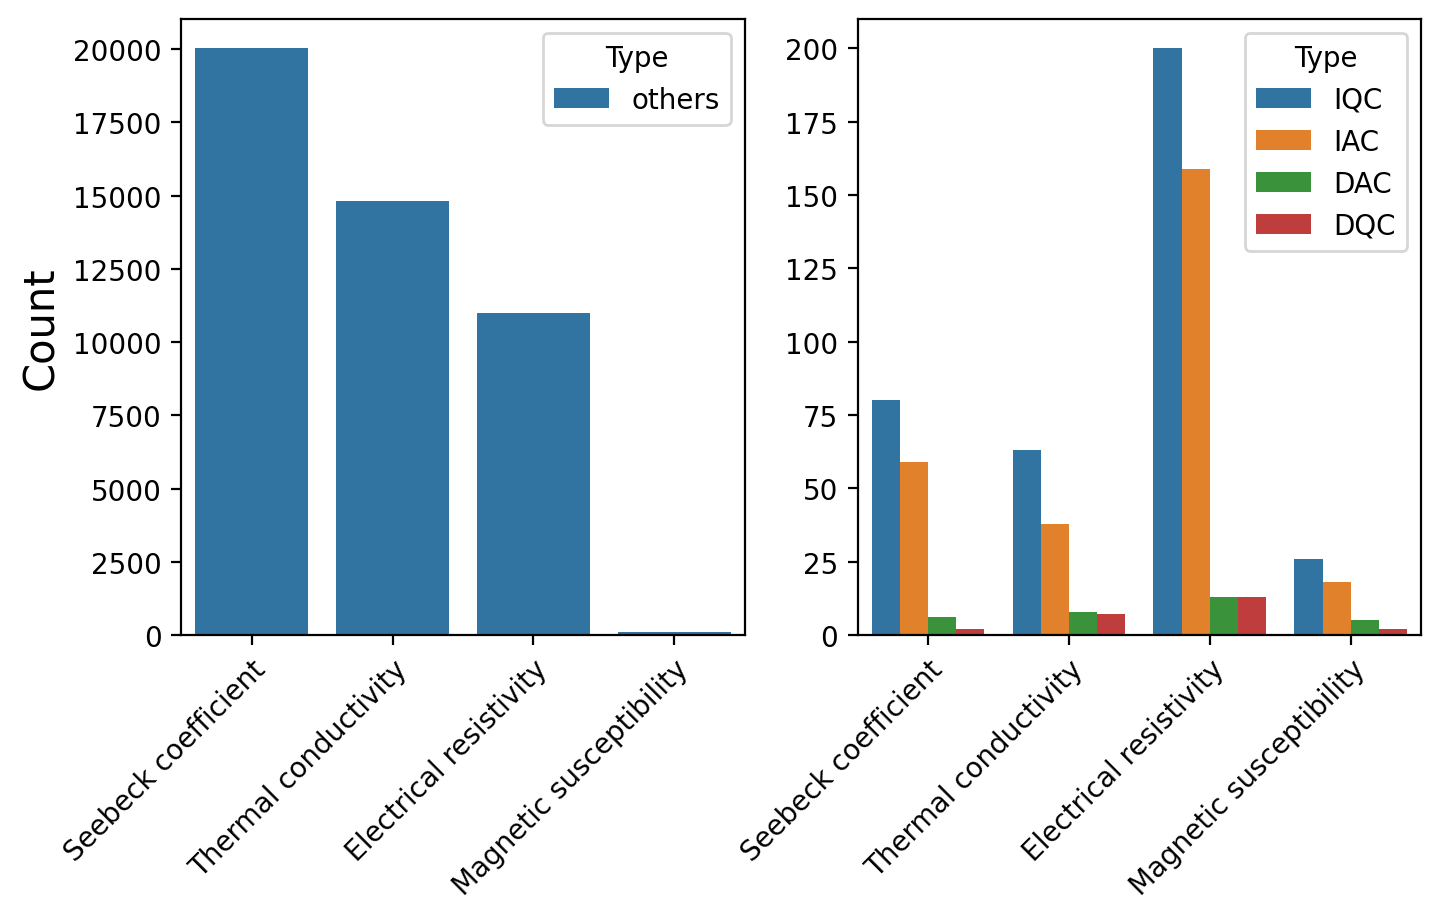

In [ ]:
tmp_ = qc_ac_te_mp_dataset.dropna(subset=["temperature"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=False)

tmp = tmp_[tmp_.hypermaterial_type == "others"]
ax = sns.countplot(tmp, x="property", hue="hypermaterial_type", ax=ax1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Count", fontsize=15)
ax.set_xlabel(None)
ax.legend(title="Type")

tmp = tmp_[tmp_.hypermaterial_type != "others"]
ax = sns.countplot(tmp, x="property", hue="hypermaterial_type", ax=ax2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.legend(title="Type")

---

(Thermal conductivity    5.199338
 dtype: float64,
 Thermal conductivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

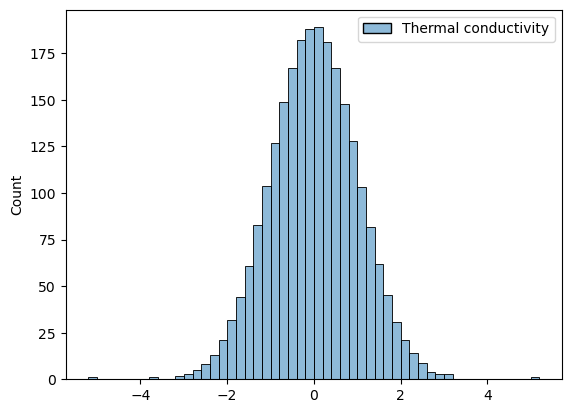

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal").set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[["Thermal conductivity"]].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Electrical resistivity    5.199338
 dtype: float64,
 Electrical resistivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

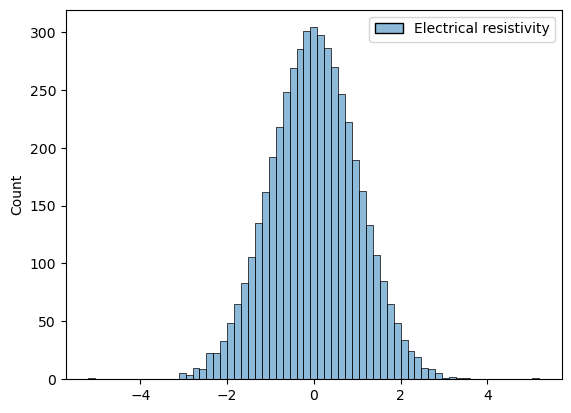

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal").set_output(transform="pandas")

a = qc_ac_te_mp_dos_rebuild[["Electrical resistivity"]].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Seebeck coefficient    5.199338
 dtype: float64,
 Seebeck coefficient   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

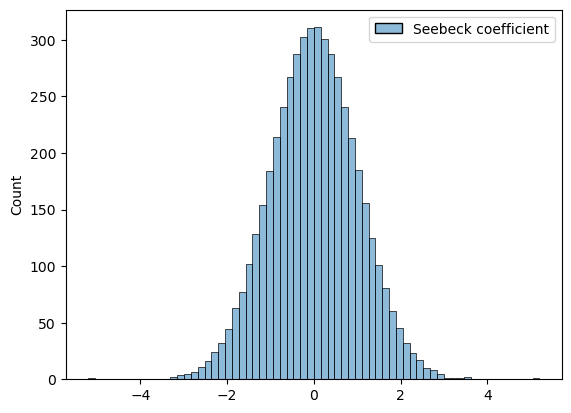

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal").set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[["Seebeck coefficient"]].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)